# Forecasting using fbprophet.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('train 2.csv')
data.head()
data.date = pd.to_datetime(data['date'])

In [3]:
data.tail()

,date,store,item,sales
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62
912999,2017-12-31,10,50,82


writing function to extract paticular item from dataframe  and removing store, item and setting date as an index and sampling sales as monthly mean. 

In [4]:
def item_function(number):
    item = data[data['item'] == number]
    item = item.drop(['store','item'], axis=1)
    item = item.set_index('date')
    item = item['sales'].resample('MS').mean()
    item = pd.DataFrame(item)
    return item

In [5]:
def plot_timeseries(axes, x, y, color, xlabel, ylabel, labels):
    plt.figure(figsize=(30,60))
    axes.plot(x, y, color=color, label=labels)
    axes.legend(loc='upper left')
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.tick_params('y',colors=color)

In [6]:
item_twentyfive = item_function(25)

Now we will write function to extract item as per the requirement by fb prophet. we will remain date column as ds and sales column as y

In [7]:
def item_prophet(number):
    item = data[data['item'] == number]
    item = item.drop(['store','item'], axis=1)
    item = pd.DataFrame(item)
    item = item.rename(columns={'date': 'ds', 'sales': 'y'})
    return item

Extracting item number 25 and seeting cap = 200 as the maximum sales on single day is 193. Here will we apply logistic growth so we cannot have some unexpected prediction.

In [8]:
item_twentyfive = item_prophet(25)
print(item_twentyfive['y'].max())
item_twentyfive['cap'] = 200
item_twentyfive

193


,ds,y,cap
438240,2013-01-01,59,200
438241,2013-01-02,26,200
438242,2013-01-03,42,200
438243,2013-01-04,35,200
438244,2013-01-05,45,200
...,...,...,...
456495,2017-12-27,65,200
456496,2017-12-28,72,200
456497,2017-12-29,93,200
456498,2017-12-30,73,200


In [9]:
def plot_timeseries(axes, x, y, color, xlabel, ylabel, labels):
    plt.figure(figsize=(30,60))
    axes.plot(x, y, color=color, label=labels)
    axes.legend(loc='upper left')
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.tick_params('y',colors=color)

Importing plotly failed. Interactive plots will not work.


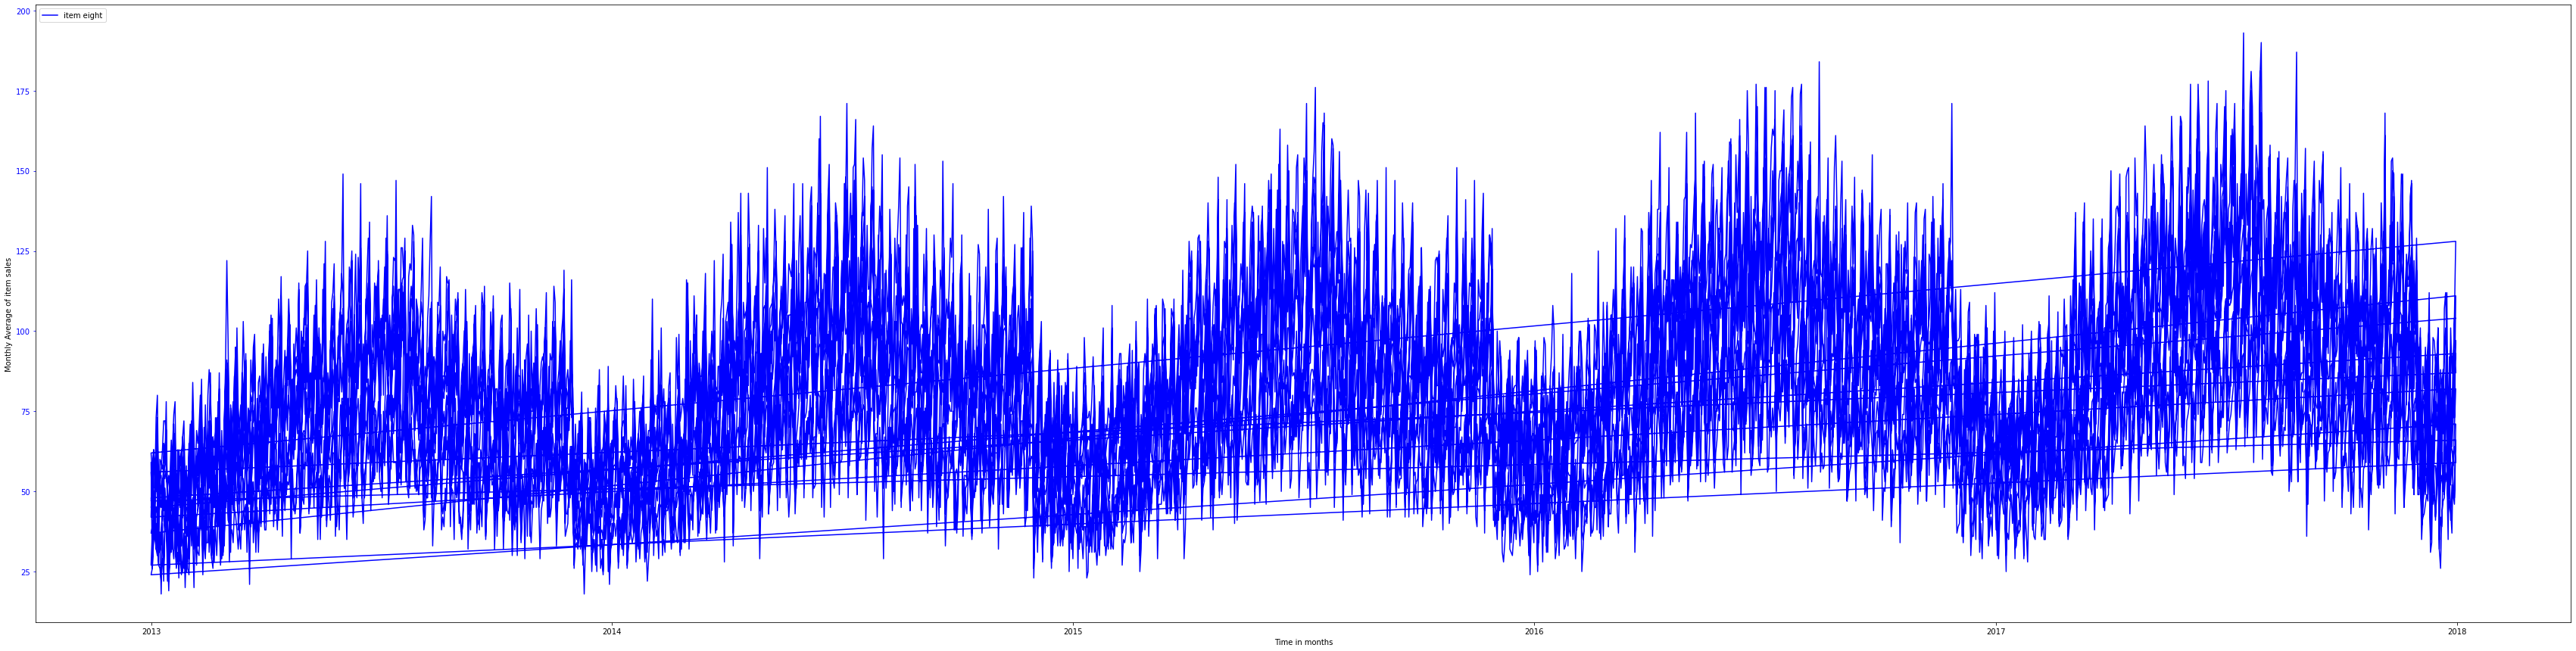

<Figure size 2160x4320 with 0 Axes>

In [10]:
from fbprophet import Prophet
fig, ax = plt.subplots(figsize=(60,15))
plot_timeseries(ax, item_twentyfive['ds'], item_twentyfive['y'], 'blue', 'Time in months', 'Monthly Average of item sales','item eight')

Above graph describes about sales of item from 2013 to 2017.

Now will Use Prophet library for prediction, setting growth as logistic, seasonality_mode as multiplicative and we will add holiday keeping country as USA

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


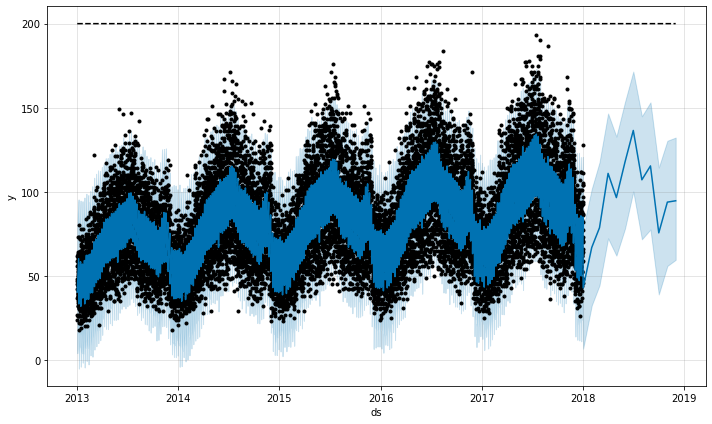

In [11]:
m = Prophet(interval_width=0.95,growth='logistic', seasonality_mode='multiplicative',changepoint_prior_scale=0.5)
m.add_seasonality('quarterly', period=91.25, fourier_order=8, mode='additive')
m.add_country_holidays(country_name='US')
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
m.fit(item_twentyfive)
item_twentyfive_forecast = m.make_future_dataframe(periods=12, freq='MS')
item_twentyfive_forecast['cap'] = 200
item_twentyfive_forecast = m.predict(item_twentyfive_forecast)
fig = m.plot(item_twentyfive_forecast)

C:\Users\Harshit Panchal\.conda\envs\textenv\lib\site-packages\fbprophet\plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)
C:\Users\Harshit Panchal\.conda\envs\textenv\lib\site-packages\fbprophet\plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)
C:\Users\Harshit Panchal\.conda\envs\textenv\lib\site-packages\fbprophet\plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)
C:\Users\Harshit Panchal\.conda\envs\textenv\lib\site-packages\fbprophet\plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)
C:\Users\Harshit Panchal\.conda\envs\textenv\lib\site-packages\fbprophet\plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)


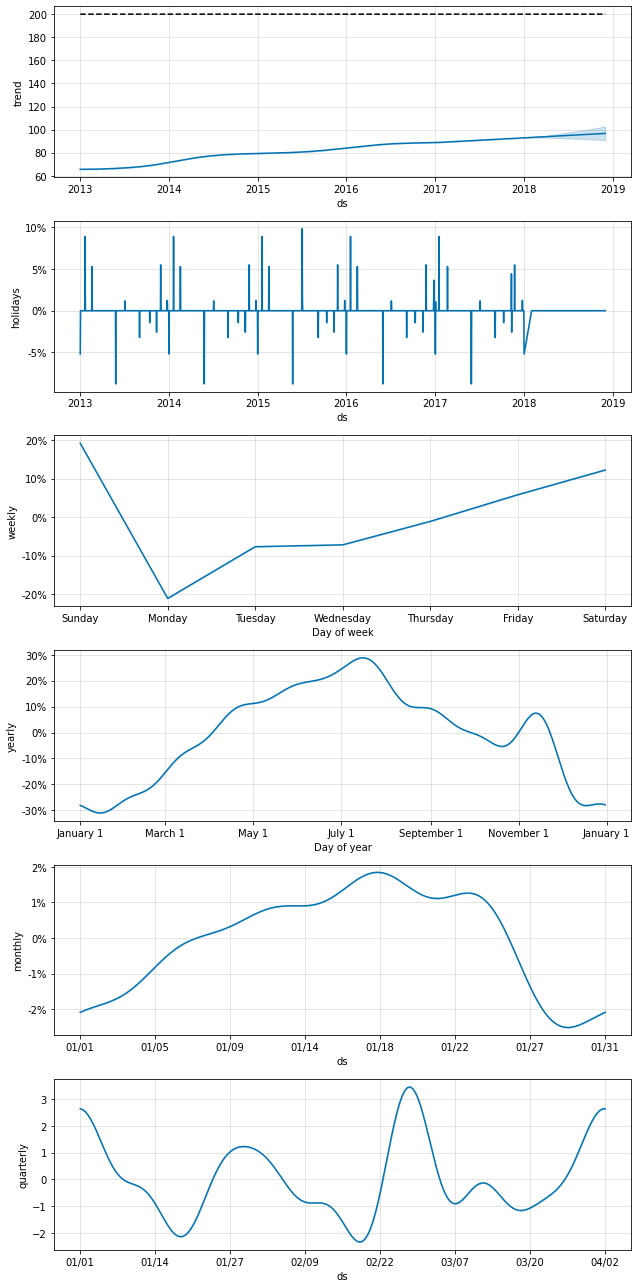

In [12]:
fig = m.plot_components(item_twentyfive_forecast)


From Componenets graph we can observe that. Trend is increasing steadily year on year which means sales is increasing. Sales On weekends are higher, Sales in middle of year is at peak. Quarterly analysis doesn't reflect any results.

**We will now plot trends changing line.**

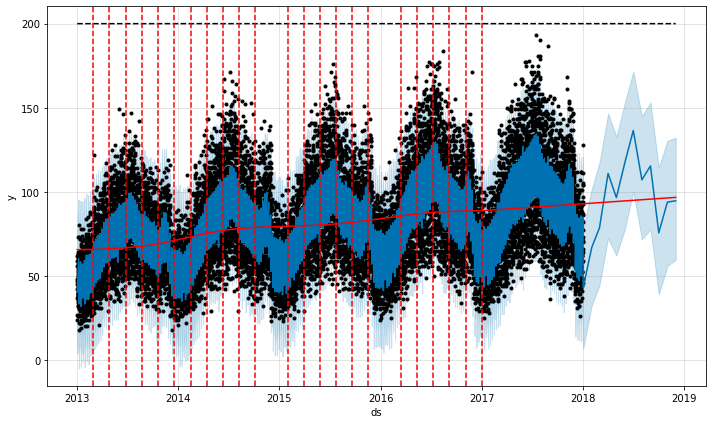

In [13]:
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(item_twentyfive_forecast)
a = add_changepoints_to_plot(fig.gca(), m, item_twentyfive_forecast)

We can observe the change in trend almost five times a year

**Now we will see the predictions, cross-validation score, and performance metrics.**

In [14]:
forecast = m.predict(item_twentyfive_forecast)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper',
          'monthly','monthly_lower','monthly_upper',
          'multiplicative_terms','multiplicative_terms_lower','multiplicative_terms_upper', 
          'trend','trend_lower','trend_upper']].head()

,ds,yhat,yhat_lower,yhat_upper,monthly,monthly_lower,monthly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,trend,trend_lower,trend_upper
0,2013-01-01,40.347530,3.211934,77.138996,-0.014332,-0.014332,-0.014332,-0.424123,-0.424123,-0.424123,65.614967,65.614967,65.614967
1,2013-01-02,44.300072,7.536228,81.535085,-0.009893,-0.009893,-0.009893,-0.365051,-0.365051,-0.365051,65.616237,65.616237,65.616237
2,2013-01-03,48.298018,10.757139,86.848215,-0.005197,-0.005197,-0.005197,-0.302037,-0.302037,-0.302037,65.617508,65.617508,65.617508
3,2013-01-04,52.566677,19.897803,88.923164,-0.001667,-0.001667,-0.001667,-0.232029,-0.232029,-0.232029,65.618778,65.618778,65.618778
4,2013-01-05,56.274166,17.887031,96.617565,0.000380,0.000380,0.000380,-0.168606,-0.168606,-0.168606,65.620048,65.620048,65.620048


In [15]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '365 days')
df_cv.head()

INFO:fbprophet:Making 5 forecasts with cutoffs between 2015-01-11 00:00:00 and 2016-12-31 00:00:00


  0%|          | 0/5 [00:00<?, ?it/s]

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2015-01-12,40.156327,7.515004,73.001614,41,2015-01-11
1,2015-01-12,40.156327,3.858152,73.182917,52,2015-01-11
2,2015-01-12,40.156327,4.209095,74.567659,48,2015-01-11
3,2015-01-12,40.156327,7.171658,74.748250,48,2015-01-11
4,2015-01-12,40.156327,5.611292,74.645579,73,2015-01-11


In [16]:
df_cv.max()

ds            2017-12-31 00:00:00
yhat                   140.788575
yhat_lower             105.851425
yhat_upper             179.330917
y                             193
cutoff        2016-12-31 00:00:00
dtype: object

In [17]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,37 days,358.148584,18.924814,15.255807,0.225307,0.173807,0.932877
1,38 days,353.419363,18.799451,15.151692,0.223999,0.172218,0.934795
2,39 days,353.462285,18.800593,15.165640,0.224022,0.173226,0.934521
3,40 days,354.599004,18.830799,15.239727,0.225403,0.173994,0.935616
4,41 days,356.200415,18.873273,15.258073,0.225536,0.174030,0.935890


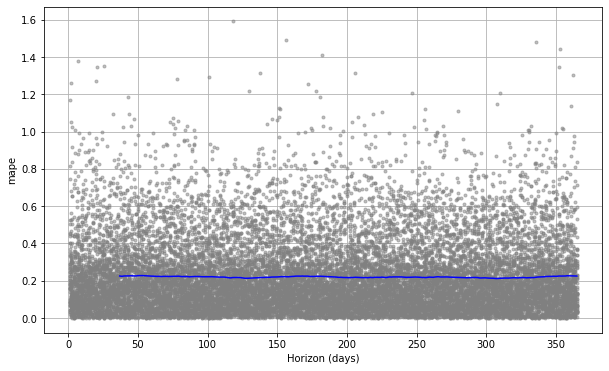

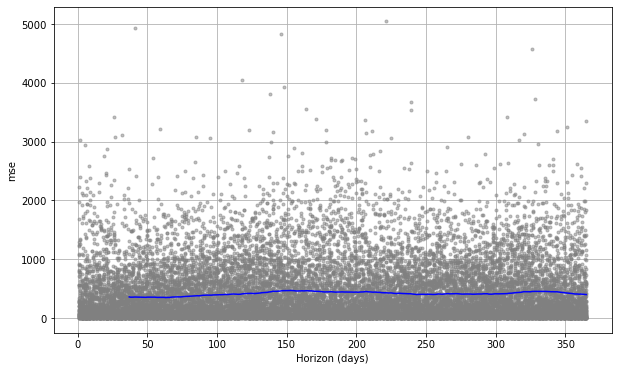

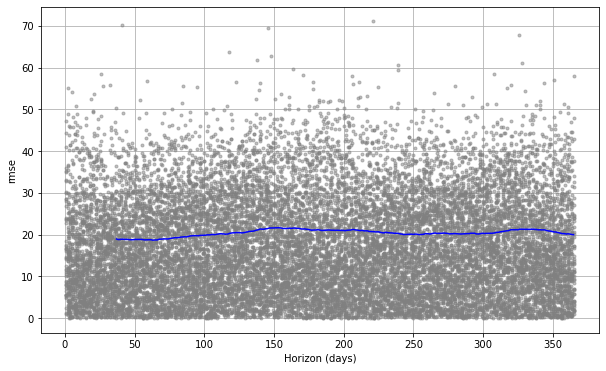

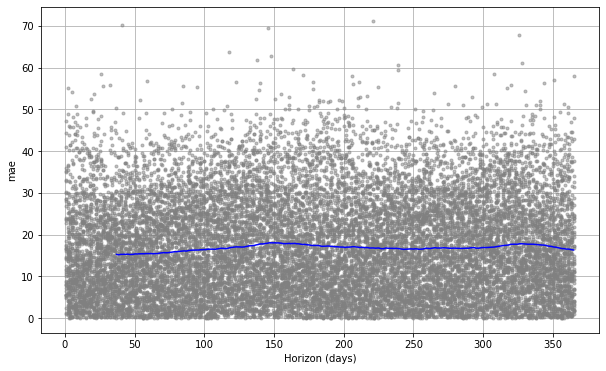

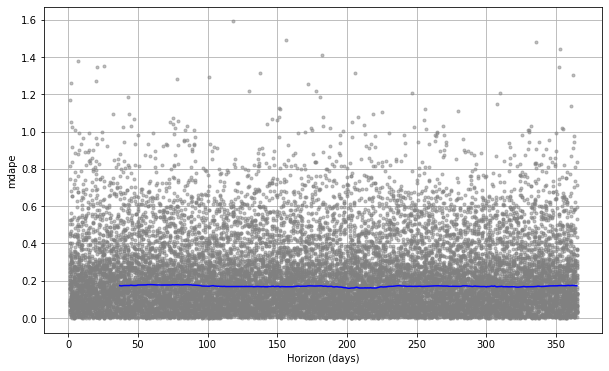

In [18]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')
fig = plot_cross_validation_metric(df_cv, metric='mse')
fig = plot_cross_validation_metric(df_cv, metric='rmse')
fig = plot_cross_validation_metric(df_cv, metric='mae')
fig = plot_cross_validation_metric(df_cv, metric='mdape')

We will find the best parameters now.

In [19]:
import itertools

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here
cutoffs = pd.to_datetime(['2014-02-15', '2014-08-15', '2015-02-15'])
# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(item_twentyfive)  # Fit model with given params
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000021546E10490>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000021547A46460>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000021546033310>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000021546E107F0>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet

    changepoint_prior_scale  seasonality_prior_scale       rmse
0                     0.001                     0.01  17.810043
1                     0.001                     0.10  17.833492
2                     0.001                     1.00  17.801889
3                     0.001                    10.00  17.815584
4                     0.010                     0.01  17.316599
5                     0.010                     0.10  17.340615
6                     0.010                     1.00  17.341816
7                     0.010                    10.00  17.328692
8                     0.100                     0.01  18.645733
9                     0.100                     0.10  17.227965
10                    0.100                     1.00  17.226454
11                    0.100                    10.00  17.226384
12                    0.500                     0.01  19.360366
13                    0.500                     0.10  17.228873
14                    0.500             

In [20]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0}


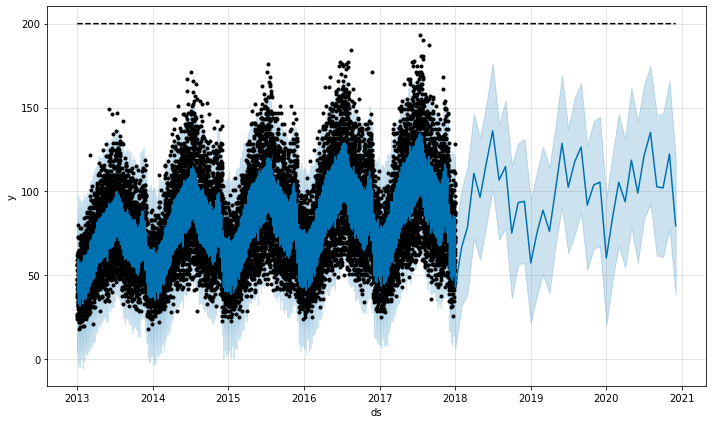

In [21]:
m = Prophet(interval_width=0.95,growth='logistic', seasonality_mode='multiplicative',
            changepoint_prior_scale=0.1, seasonality_prior_scale=10.0, daily_seasonality=True)
m.add_seasonality('quarterly', period=91.25, fourier_order=8, mode='additive')
m.add_country_holidays(country_name='US')
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
m.fit(item_twentyfive)
item_twentyfive_forecast = m.make_future_dataframe(periods=36, freq='MS')
item_twentyfive_forecast['cap'] = 200
item_twentyfive_forecast = m.predict(item_twentyfive_forecast)
fig = m.plot(item_twentyfive_forecast)

**Saving the model**

In [22]:
import json
from fbprophet.serialize import model_to_json, model_from_json

with open('serialized_model.json', 'w') as fout:
    json.dump(model_to_json(m), fout)  # Save model

with open('serialized_model.json', 'r') as fin:
    m = model_from_json(json.load(fin))  # Load model

In [23]:
def stan_init(m):
    """Retrieve parameters from a trained model.
    
    Retrieve parameters from a trained model in the format
    used to initialize a new Stan model.
    
    Parameters
    ----------
    m: A trained model of the Prophet class.
    
    Returns
    -------
    A Dictionary containing retrieved parameters of m.
    
    """
    res = {}
    for pname in ['k', 'm', 'sigma_obs']:
        res[pname] = m.params[pname][0][0]
    for pname in ['delta', 'beta']:
        res[pname] = m.params[pname][0]
    return res

df = item_prophet(35)
df1 = df.loc[df['ds'] < '2017-12-30', :]  # All data except the last day
m1 = Prophet().fit(df1) # A model fit to all data except the last day


%timeit m2 = Prophet(interval_width=0.95,growth='flat', seasonality_mode='multiplicative',daily_seasonality=True).fit(df)  # Adding the last day, fitting from scratch
%timeit m2 = Prophet().fit(df, init=stan_init(m1))  # Adding the last day, warm-starting from m1

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


775 ms ± 8.42 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


928 ms ± 26.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


**Doing the forecast on saved model**

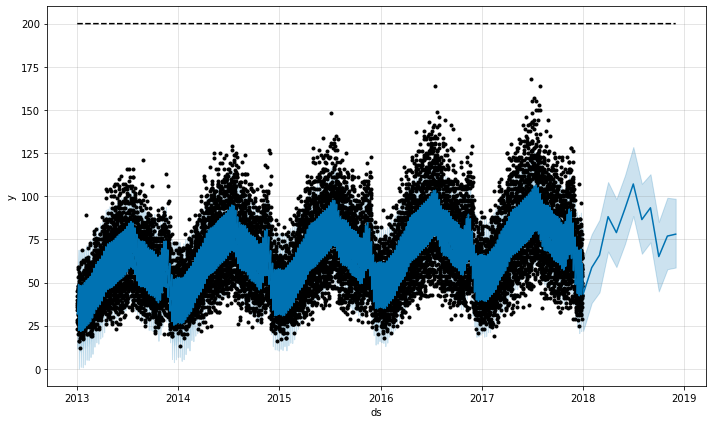

In [24]:
item_thirtyfive_forecast = m1.make_future_dataframe(periods=12, freq='MS')
item_thirtyfive_forecast['cap'] = 200
forecast = m1.predict(item_thirtyfive_forecast)
fig = m1.plot(forecast)

In [25]:
df_cv = cross_validation(m1, initial='730 days', period='180 days', horizon = '365 days')
df_cv.head()

INFO:fbprophet:Making 5 forecasts with cutoffs between 2015-01-09 00:00:00 and 2016-12-29 00:00:00


  0%|          | 0/5 [00:00<?, ?it/s]

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2015-01-10,55.707015,37.526500,72.964171,50,2015-01-09
1,2015-01-10,55.707015,38.012778,74.265309,51,2015-01-09
2,2015-01-10,55.707015,37.560180,73.509291,59,2015-01-09
3,2015-01-10,55.707015,38.311655,73.907861,60,2015-01-09
4,2015-01-10,55.707015,36.542258,74.605936,46,2015-01-09


In [26]:
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,37 days,247.364868,15.727837,12.709310,0.229823,0.172519,0.751781
1,38 days,247.940876,15.746138,12.702079,0.229834,0.171642,0.752877
2,39 days,247.369818,15.727995,12.683934,0.229818,0.174584,0.754521
3,40 days,246.508396,15.700586,12.674162,0.229830,0.172658,0.755068
4,41 days,247.356312,15.727565,12.692413,0.229809,0.171642,0.754247


### Here we can observe that forecasting by saved model is done well as rmse value is decreased. 